# Spring 2022 Math168 Final Project 
## Group name: Petwork Pawfessionals  
### Members: Jaya Ren, Laura Li, Chris Li  


## Scientific questions: 
How do online user interactions evolve over time? What factors contribute to stable online relationships? Can we predict the stability of relationship between two users based on their history of interactions? These questions are not only important to individual users, but also to owners/developers of the online communities for understanding and predicting user behaviors and preferences.  
To address this problem, we plan to examine the relationship between pairs of users based on the posts between users where each post will form an edge between two users, and how it has changed over time.   
To analyze the graph we created, we plan to first develop some features to measure the active-
ness/stability of users by exploring features of the given network data, including clustering coefficient,
community detection, Jaccard coefficient, etc. The result will show the brief overview of users interaction in the social media platform of our choice.  
After we understand both link structure and their behavior, we plan to develop some predictive models with some model improvement techiques that make a prediction of users interaction in near future.  

## Anticipated Learnings
Our coursework so far has laid a strong foundation for our project: we will be able to apply the knowledge
we learned, such as graph structure, to gain a better understanding of the structure of our chosen network, and applying machine learning algorithm.
With that being said, there are many methods that we haven’t learned but want to apply to our data,
to be specific, the temporal analysis and predictive analysis. However, they are crucial to achieving our
goal of this project: temporal analysis will help us understand how online social relationships evolve,
while predictive analysis will help us understand this even further. These two methods together will
help provide great insights to the stability of online communication, which we can further build upon to
provide suggestions for a healthier and stabler online community. We are very excited about our project
and will be very proud of what we learn.


# <span style="color:red">Warning!</span>
## Since we have a giantic data (almost 1M of edges), it could take hours or longer to process the program. We are really sorry if it crashed your computer and appreciate your patience and understanding.

# Import packages

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## Split data (7:3)

In [2]:
train = pd.read_csv("before.csv")
test = pd.read_csv("after.csv")

In [3]:
np.round(len(train) / (len(test) + len(train)), 2)

0.7

In [4]:
np.round(len(test) / (len(test) + len(train)), 2)

0.3

In [5]:
train = train.rename(columns = {"from": "source", "to": "target"})[["source", "target"]]
test = test.rename(columns = {"from":"source", "to":"target"})[["source", "target"]]

In [6]:
train_nodes = np.unique(np.concatenate([train.source, train.target]))

# we are only going to attempt to make predictions about the existence of an 
# edge between two nodes in cases when both nodes had at least one edge 
# in the training data. 

test["found_source"] = test.source.map(lambda x: x in train_nodes)
test["found_target"] = test.target.map(lambda x: x in train_nodes)
test = test[test.found_source & test.found_target]
test = test.drop(['found_source', 'found_target'], axis = 1)

In [7]:
train   = train.groupby(["source", "target"]).count().reset_index()
test    = test.groupby(["source", "target"]).count().reset_index()

In [8]:
np.round(len(train) / (len(test) + len(train)), 2)

0.83

In [9]:
np.round(len(test) / (len(test) + len(train)), 2)

0.17

After filtering the data, our training set and testing set ratio is approximately 8:2 

In [10]:
train

,source,target
0,1,20
1,2,3
2,2,9
3,2,17
4,2,18
...,...,...
232576,63047,63048
232577,63088,63089
232578,63138,63238
232579,63141,63142


In [11]:
test

,source,target
0,1,24
1,3,4223
2,13,1008
3,13,3208
4,13,3212
...,...,...
49111,61664,61665
49112,61958,61959
49113,62055,62056
49114,62713,62714


In [12]:
G_train = nx.from_pandas_edgelist(train)
G_test = nx.from_pandas_edgelist(test)

In [13]:
print(G_train)

Graph with 42166 nodes and 232581 edges


In [14]:
print(G_test)

Graph with 24965 nodes and 49116 edges


In [15]:
train_w_neg = pd.read_csv("before_fake_edges.csv")
test_w_neg = pd.read_csv("after_fake_edges.csv")

In [16]:
def add_negative_examples(G ,df):

    # new copy of input data frame, with a new column
    df_ = df
    df_["link"] = 1

    node_list = np.array(list(dict(G.nodes)))
    
    G = nx.from_pandas_edgelist(df_)
    edge = list(G.edges)
    negative = pd.DataFrame(columns = ['source', 'target'])
    node_list.sort()
    n = int(G.number_of_nodes() / 10)
    m = int(G.number_of_edges() * 3 / n)
    node_list_without_l = [x for x in node_list if x not in node_list[-(m+10):]]
    
    for i in range(n):
        node_1 = random.choice(np.asarray(node_list_without_l))
        connected_nodes = [n for _, n in G.edges(node_1)]
        feasible_nodes = [feasible_n for feasible_n in node_list[node_list > node_1] if feasible_n not in connected_nodes + [node_1]]
        node_1_c = list(np.ones(m, dtype=int) * node_1)
        node_2 = list(np.random.choice(feasible_nodes, m, False))
        combined = pd.DataFrame({"source":node_1_c,"target":node_2})
        negative = negative.append(combined, ignore_index=True)
        node_list = np.delete(node_list, np.where(node_list == node_1))
        
    # add real data and make a column distinguishing positive from negative examples
    merged_df = df_.append(negative, ignore_index=True)
    merged_df["link"] = merged_df["link"] == 1
    return merged_df

In [17]:
# train_w_neg = add_negative_examples(G_train, train)

In [18]:
# train_w_neg.sort_values("link", ascending = False)

In [19]:
# Storing data
# train_w_neg.to_csv('before_fake_edges.csv',index=False)

In [20]:
# train_w_neg["link"].mean()

## Compute Features 

1. Degree:  
The degree of a node is the number of connections that it has to other nodes in the network.


2. Degree Centrality:  
The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.


3. Clustering Coefficient:  
In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.


4. Louvain Communities:
Louvain Community Detection Algorithm is a simple method to extract the community structure of a network. This is a heuristic method based on modularity optimization.  


5. Greedy Modularity Communities:  
This function uses Clauset-Newman-Moore greedy modularity maximization to find the community partition with the largest modularity.


6. Jaccard Coefficient:  
It is calculated by number of common neighbors normalized by total number of neighbors. It is used to measure the similarity between two finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets.  


7. Adamic Adar Index:  
The Adamic/Adar index is a measure introduced in 2003 by Lada Adamic and Eytan Adar to predict links in a social network, according to the number of shared links between two nodes. It is defined as the sum of the inverse logarithmic degree centrality of the neighbors shared by the two nodes.  


8. Preferential Attachment:  
Preferential attachment means that the more connected a node is, the more likely it is to receive new links. Nodes with higher degree gets more neighbors.


9. Resource Allocation Index:  
Among a number of similarity-based methods to predict missing links in a complex network, Research Allocation Index performs well with lower time complexity. It is defined as a fraction of a resource that a node can send to another through their common neighbors.


In [21]:
def compute_deg_features(df, G = None):
    # make the graph if it's not supplied externally
    if not G:
        edges = df[df["link"]]
        G = nx.from_pandas_edgelist(edges)
    # columns for degree of each node in G
    df["deg_source"] = df.source.apply(lambda x: G.degree(x))
    df["deg_target"] = df.target.apply(lambda x: G.degree(x))
    return df

In [22]:
def compute_deg_cen_features(df, G = None):
    # make the graph if it's not supplied externally
    if not G:
        edges = df[df["link"]]
        G = nx.from_pandas_edgelist(edges)
    a = [i for i in nx.degree_centrality(G).items()]
    a= np.array(a)
    df["deg_cen_source"] = df.source.apply(lambda x: a[np.where(a==x)[0][0]][1])
    df["deg_cen_target"] = df.target.apply(lambda x: a[np.where(a==x)[0][0]][1])
    return df

In [23]:
def compute_clustering_coeff_features(df, G = None):
    # make the graph if it's not supplied externally
    if not G:
        edges = df[df["link"]]
        G = nx.from_pandas_edgelist(edges)
    cc = [i for i in nx.clustering(G).items()]
    cc = np.array(cc)
    df["clustering_coeff_source"] = df.source.apply(lambda x: cc[np.where(cc==x)[0][0]][1])
    df["clustering_coeff_target"] = df.target.apply(lambda x: cc[np.where(cc==x)[0][0]][1])
    return df

In [24]:
def compute_comm_features(df, G = None, comm_dict = None):
    # make the community labels if not supplied externally. 
    if not comm_dict: 
        comm_dict = louvain_communities(G)
    # communities of each node in G
    comm_source = df.source.apply(lambda x: comm_dict[x])
    comm_target = df.target.apply(lambda x: comm_dict[x])

    # number of common neighbors -- networkx has a handy function that does
    # this for us! Just gotta get a little fancy with the anonymous function 
    # calls. 
    df["common_neighbors"] = df[["source", "target"]].apply(lambda pair: len(list(nx.common_neighbors(G, pair.source, pair.target))), axis = 1)
    
    # whether source node and target node are in the same community. 
    df["same_louvain_community"] = (comm_source == comm_target)
    return df

In [25]:
def compute_greedy_modularity_comm_features(df, G = None, comm_dict = None):
    # make the community labels if not supplied externally. 
    if not comm_dict: 
        comm_dict = greedy_modularity_communities(G)
    # communities of each node in G
    comm_source = df.source.apply(lambda x: comm_dict[x])
    comm_target = df.target.apply(lambda x: comm_dict[x])
    
    # whether source node and target node are in the same community. 
    df["same_greedy_modularity_community"] = (comm_source == comm_target)
    return df

In [26]:
def louvain_communities(G, return_partition = False):

    # run Louvain
    comms  = nx.community.louvain_communities(G, resolution = 1)

    # process the labels
    labels = [l for i in G.nodes for l in range(len(comms)) if i in comms[l]]
    node_list = list(G.nodes)
    comm_dict = {node_list[i] : labels[i] for i in range(len(node_list))}
    
    if return_partition:
        return comm_dict, comms

    return comm_dict

In [27]:
def greedy_modularity_communities(G, return_partition = False):

    # run Louvain
    comms  = nx.community.greedy_modularity_communities(G, resolution = 1)

    # process the labels
    labels = [l for i in G.nodes for l in range(len(comms)) if i in comms[l]]
    node_list = list(G.nodes)
    comm_dict = {node_list[i] : labels[i] for i in range(len(node_list))}
    
    if return_partition:
        return comm_dict, comms

    return comm_dict

In [28]:
def compute_jaccard_coef(df, G):
    J = []
    for i in range(df.shape[0]):
        a = df['source'][i]
        b = df['target'][i]
        pred = nx.jaccard_coefficient(G, [(a, b)])
        for u, v ,p in pred:
            J.append(p)
    df['jaccard_coefficient'] = J
    return df

In [29]:
def compute_adamic_adar_index(df, G):
    a_a_i = []
    for i in range(df.shape[0]):
        a = df['source'][i]
        b = df['target'][i]
        pred = nx.adamic_adar_index(G, [(a, b)])
        for u, v ,p in pred:
            a_a_i.append(p)
    df['adamic_adar_index'] = a_a_i
    return df

In [30]:
def compute_preferential_attachment(df, G):
    prefer_a = []
    for i in range(df.shape[0]):
        a = df['source'][i]
        b = df['target'][i]
        pred = nx.preferential_attachment(G, [(a, b)])
        for u, v ,p in pred:
            prefer_a.append(p)
    df['preferential_attachment'] = prefer_a
    return df

In [31]:
def compute_resource_allocation_index(df, G):
    res_allo_idx = []
    for i in range(df.shape[0]):
        a = df['source'][i]
        b = df['target'][i]
        pred = nx.resource_allocation_index(G, [(a, b)])
        for u, v ,p in pred:
            res_allo_idx.append(p)
    df['resource_allocation_index'] = res_allo_idx
    return df

In [32]:
# comm_dict_train = louvain_communities(G_train)

In [33]:
# greedy_modularity_dict_train = greedy_modularity_communities(G_train)

In [34]:
# train_feat = compute_deg_features(train_w_neg, G_train)

In [35]:
# train_feat = compute_deg_cen_features(train_feat, G_train)

In [36]:
# train_feat = compute_clustering_coeff_features(train_feat, G_train)

In [37]:
# train_feat = compute_comm_features(train_feat, G_train, comm_dict_train)

In [38]:
# train_feat = compute_greedy_modularity_comm_features(train_feat, G_train, greedy_modularity_dict_train)

In [39]:
# train_feat = compute_jaccard_coef(train_feat, G_train)

In [40]:
# train_feat = compute_adamic_adar_index(train_feat, G_train)

In [41]:
# train_feat = compute_preferential_attachment(train_feat, G_train)

In [42]:
# train_feat = compute_resource_allocation_index(train_feat, G_train)

In [43]:
train_feat = pd.read_csv("before_fake_edges_w_features.csv")

In [184]:
train_feat

,source,target,link,deg_source,deg_target,clustering_coeff_source,clustering_coeff_target,common_neighbors,same_louvain_community,same_greedy_modularity_community,jaccard_coefficient,adamic_adar_index,preferential_attachment,resource_allocation_index
0,1,20,True,1,7,0.00,0.00,0,True,True,0.00,0.00,7,0.00
1,2,3,True,15,15,0.13,0.08,1,True,False,0.03,0.46,225,0.11
2,2,9,True,15,91,0.13,0.03,2,False,False,0.02,0.75,1365,0.14
3,2,17,True,15,11,0.13,0.11,3,True,True,0.13,1.22,165,0.29
4,2,18,True,15,10,0.13,0.04,2,True,True,0.09,0.63,150,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928216,38155,46371,False,2,1,1.00,0.00,0,False,False,0.00,0.00,2,0.00
928217,38155,55343,False,2,2,1.00,0.00,0,False,False,0.00,0.00,4,0.00
928218,38155,40751,False,2,3,1.00,0.33,0,False,False,0.00,0.00,6,0.00
928219,38155,42967,False,2,5,1.00,0.40,0,False,False,0.00,0.00,10,0.00


In [45]:
# Storing data
# train_feat.to_csv('before_fake_edges_w_features.csv', index=False)

In [46]:
# test_w_neg = add_negative_examples(G_test, test)

In [47]:
# Storing data
# test_w_neg.to_csv('after_fake_edges.csv',index=False)

In [48]:
# test_feat = compute_deg_features(test_w_neg, G_train)

In [49]:
# test_feat = compute_deg_cen_features(test_w_neg, G_train)

In [50]:
# test_feat = compute_clustering_coeff_features(test_w_neg, G_train)

In [51]:
# test_feat = compute_comm_features(test_w_neg, G_train, comm_dict_train)

In [52]:
# test_feat = compute_greedy_modularity_comm_features(test_feat, G_train, greedy_modularity_dict_train)

In [53]:
# test_feat = compute_jaccard_coef(test_feat, G_train)

In [54]:
# test_feat = compute_adamic_adar_index(test_feat, G_train)

In [55]:
# test_feat = compute_preferential_attachment(test_feat, G_train)

In [56]:
# test_feat = compute_resource_allocation_index(test_feat, G_train)

In [57]:
# Storing data
# test_feat.to_csv('after_fake_edges_w_features.csv', index=False)

In [58]:
# test_feat = compute_resource_allocation_index(test_feat, G_train)

In [59]:
test_feat = pd.read_csv("after_fake_edges_w_features.csv")

In [60]:
test_feat

,source,target,link,deg_source,deg_target,clustering_coeff_source,clustering_coeff_target,common_neighbors,same_louvain_community,same_greedy_modularity_community,jaccard_coefficient,adamic_adar_index,preferential_attachment,resource_allocation_index
0,1,24,True,1,26,0.000000,0.018462,0,True,True,0.00,0.00000,26,0.000000
1,3,4223,True,15,11,0.076190,0.090909,1,False,False,0.04,0.40243,165,0.083333
2,13,1008,True,15,2,0.200000,1.000000,0,True,True,0.00,0.00000,30,0.000000
3,13,3208,True,15,3,0.200000,0.333333,0,False,False,0.00,0.00000,45,0.000000
4,13,3212,True,15,3,0.200000,0.000000,0,False,True,0.00,0.00000,45,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196375,38391,42519,False,14,6,0.098901,0.400000,0,False,False,0.00,0.00000,84,0.000000
196376,38391,46354,False,14,3,0.098901,0.333333,0,True,False,0.00,0.00000,42,0.000000
196377,38391,38854,False,14,33,0.098901,0.104167,0,False,False,0.00,0.00000,462,0.000000
196378,38391,40117,False,14,6,0.098901,0.266667,0,False,False,0.00,0.00000,84,0.000000


In [61]:
feature_cols = [col for col in train_feat.columns if col not in ["source", "target", "link"]]

X_train = train_feat[feature_cols]
y_train = train_feat["link"]
X_test = test_feat[feature_cols]
y_test = test_feat["link"]

In [62]:
X_train

,deg_source,deg_target,clustering_coeff_source,clustering_coeff_target,common_neighbors,same_louvain_community,same_greedy_modularity_community,jaccard_coefficient,adamic_adar_index,preferential_attachment,resource_allocation_index
0,1,7,0.000000,0.000000,0,True,True,0.000000,0.000000,7,0.000000
1,15,15,0.133333,0.076190,1,True,False,0.034483,0.455120,225,0.111111
2,15,91,0.133333,0.027595,2,False,False,0.019231,0.750841,1365,0.140909
3,15,11,0.133333,0.109091,3,True,True,0.130435,1.217954,165,0.294726
4,15,10,0.133333,0.044444,2,True,True,0.086957,0.634706,150,0.114928
...,...,...,...,...,...,...,...,...,...,...,...
928216,2,1,1.000000,0.000000,0,False,False,0.000000,0.000000,2,0.000000
928217,2,2,1.000000,0.000000,0,False,False,0.000000,0.000000,4,0.000000
928218,2,3,1.000000,0.333333,0,False,False,0.000000,0.000000,6,0.000000
928219,2,5,1.000000,0.400000,0,False,False,0.000000,0.000000,10,0.000000


# Variance Inflation Factor (VIF)

A variance inflation factor(VIF) detects multicollinearity in regression analysis. Multicollinearity is when there’s correlation between predictors (i.e. independent variables) in a model; it’s presence can adversely affect the regression results. The VIF estimates how much the variance of a regression coefficient is inflated due to multicollinearity in the model.

In [63]:
X1_train=X_train.loc[:, ~X_train.columns.isin(['same_greedy_modularity_community', 'same_louvain_community'])]
X1_test=X_test.loc[:, ~X_test.columns.isin(['same_greedy_modularity_community', 'same_louvain_community'])]

In [64]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

x_temp = sm.add_constant(X1_train)

vif = pd.DataFrame()
vif["features"] = x_temp.columns
vif["VIF"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
print(vif.round(2))

                    features      VIF
0                      const     2.84
1                 deg_source     2.00
2                 deg_target     2.42
3    clustering_coeff_source     1.02
4    clustering_coeff_target     1.03
5           common_neighbors  1476.12
6        jaccard_coefficient     3.98
7          adamic_adar_index  2680.77
8    preferential_attachment     4.23
9  resource_allocation_index   250.68


We can see that 'common neighbors' is highly correlated with Adamic-Adar index. However, common neighbors feature did not offer much extra information that Adamic-Adar index and Jaccard coefficient already have. Therefore, it become less significant than the other features. So, we could simply drop the common neighbors feature.

In [65]:
vif_data = pd.DataFrame()
vif_data["feature"] = X1_train.columns
vif_data["VIF"] = [variance_inflation_factor(X1_train.values, i) for i in range(len(X1_train.columns))]

In [66]:
vif_data

,feature,VIF
0,deg_source,2.325377
1,deg_target,2.797863
2,clustering_coeff_source,1.196619
3,clustering_coeff_target,1.229899
4,common_neighbors,1632.363373
5,jaccard_coefficient,4.443203
6,adamic_adar_index,2985.019338
7,preferential_attachment,4.242265
8,resource_allocation_index,276.340505


In [67]:
X_train = X_train.drop(['common_neighbors'],axis =1)
X_test = X_test.drop(['common_neighbors'],axis =1)

In [68]:
X2_train=X_train.loc[:, ~X_train.columns.isin(['same_greedy_modularity_community', 'same_louvain_community'])]
X2_test=X_test.loc[:, ~X_test.columns.isin(['same_greedy_modularity_community', 'same_louvain_community'])]

In [69]:
x_temp = sm.add_constant(X2_train)

vif = pd.DataFrame()
vif["features"] = x_temp.columns
vif["VIF"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
print(vif.round(2))

                    features   VIF
0                      const  2.84
1                 deg_source  1.99
2                 deg_target  2.41
3    clustering_coeff_source  1.02
4    clustering_coeff_target  1.03
5        jaccard_coefficient  3.97
6          adamic_adar_index  8.99
7    preferential_attachment  4.06
8  resource_allocation_index  6.65


In [70]:
vif_data = pd.DataFrame()
vif_data["feature"] = X2_train.columns
vif_data["VIF"] = [variance_inflation_factor(X2_train.values, i) for i in range(len(X2_train.columns))]

In [71]:
vif_data

,feature,VIF
0,deg_source,2.315688
1,deg_target,2.793162
2,clustering_coeff_source,1.196491
3,clustering_coeff_target,1.229678
4,jaccard_coefficient,4.439117
5,adamic_adar_index,9.963227
6,preferential_attachment,4.058808
7,resource_allocation_index,7.319540


In [72]:
X_train = X2_train
X_test = X2_test

# Principal component analysis (PCA)

Principal component analysis, or PCA, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other.

In [73]:
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
from sklearn import preprocessing

SS = preprocessing.StandardScaler()
X_train_ss = SS.fit_transform(X_train)
X_test_ss = SS.transform(X_test)

In [74]:
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
np.var(X_train_ss)

deg_source                   1.0
deg_target                   1.0
clustering_coeff_source      1.0
clustering_coeff_target      1.0
jaccard_coefficient          1.0
adamic_adar_index            1.0
preferential_attachment      1.0
resource_allocation_index    1.0
dtype: float64

In [75]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_p = pca.fit_transform(X_train_ss)
X_test_p = pca.transform(X_test_ss)

In [76]:
X_train_p = pd.DataFrame(X_train_p, columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6","PC7","PC8"])
X_test_p = pd.DataFrame(X_test_p, columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6","PC7","PC8"])

In [77]:
X_train_p

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.896230,0.198442,0.012708,-0.836644,0.354771,0.104436,0.054549,-0.005557
1,0.946220,-0.747301,-0.267615,-0.444197,0.113737,-0.047579,-0.297142,0.342693
2,3.229530,1.173559,-0.807631,0.263871,3.173812,-0.978947,-1.515524,0.349641
3,3.623899,-3.162567,-0.218977,-1.503699,-0.315120,-0.325291,0.125336,0.982816
4,1.589441,-1.576627,-0.372073,-0.901894,-0.168568,-0.609339,0.616306,0.295951
...,...,...,...,...,...,...,...,...
928216,-1.086368,-1.681096,-3.720174,2.888280,-0.325505,0.324206,-0.041990,-0.021403
928217,-1.063867,-1.661594,-3.724329,2.897919,-0.285753,0.299690,-0.057350,-0.021008
928218,-0.973044,-2.109857,-2.551659,3.869529,-0.131269,0.354803,-0.111749,-0.037403
928219,-0.914377,-2.164407,-2.324603,4.081201,-0.028818,0.321698,-0.150278,-0.039971


In [78]:
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6","PC7","PC8"], index=X_train.columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
deg_source,0.329024,0.408857,0.073680,0.191922,-0.719562,-0.353528,-0.197072,-0.026985
deg_target,0.372929,0.320080,-0.070017,0.158709,0.678347,-0.436397,-0.278899,-0.000010
clustering_coeff_source,-0.012568,-0.316087,-0.667130,0.669477,-0.073336,0.014805,-0.032651,-0.002444
clustering_coeff_target,0.042742,-0.292634,0.736222,0.601810,0.071777,0.049815,-0.024423,-0.010504
jaccard_coefficient,0.403850,-0.440237,-0.003159,-0.167289,-0.040687,-0.486755,0.603029,0.113449
adamic_adar_index,0.483193,-0.196741,-0.032202,-0.132187,-0.009054,0.290468,-0.123321,-0.780798
preferential_attachment,0.397369,0.445430,-0.036061,0.203881,0.074385,0.535058,0.511318,0.218071
resource_allocation_index,0.442955,-0.337512,-0.015394,-0.201435,-0.065388,0.272554,-0.491343,0.573659


In [79]:
pca.explained_variance_ratio_

array([0.46371659, 0.17039123, 0.12203922, 0.11863646, 0.07234755,
       0.02460026, 0.01913865, 0.00913005])

In [80]:
np.cumsum(pca.explained_variance_ratio_)

array([0.46371659, 0.63410782, 0.75614703, 0.87478349, 0.94713104,
       0.9717313 , 0.99086995, 1.        ])

In [81]:
X_train_p["same_louvain_community"]=train_feat["same_louvain_community"]
X_test_p["same_louvain_community"]=test_feat["same_louvain_community"]

In [82]:
X_train_p["same_greedy_modularity_community"]=train_feat["same_greedy_modularity_community"]
X_test_p["same_greedy_modularity_community"]=test_feat["same_greedy_modularity_community"]

In [83]:
X_train = X_train_p
X_test = X_test_p

In [84]:
X_train

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,same_louvain_community,same_greedy_modularity_community
0,-0.896230,0.198442,0.012708,-0.836644,0.354771,0.104436,0.054549,-0.005557,True,True
1,0.946220,-0.747301,-0.267615,-0.444197,0.113737,-0.047579,-0.297142,0.342693,True,False
2,3.229530,1.173559,-0.807631,0.263871,3.173812,-0.978947,-1.515524,0.349641,False,False
3,3.623899,-3.162567,-0.218977,-1.503699,-0.315120,-0.325291,0.125336,0.982816,True,True
4,1.589441,-1.576627,-0.372073,-0.901894,-0.168568,-0.609339,0.616306,0.295951,True,True
...,...,...,...,...,...,...,...,...,...,...
928216,-1.086368,-1.681096,-3.720174,2.888280,-0.325505,0.324206,-0.041990,-0.021403,False,False
928217,-1.063867,-1.661594,-3.724329,2.897919,-0.285753,0.299690,-0.057350,-0.021008,False,False
928218,-0.973044,-2.109857,-2.551659,3.869529,-0.131269,0.354803,-0.111749,-0.037403,False,False
928219,-0.914377,-2.164407,-2.324603,4.081201,-0.028818,0.321698,-0.150278,-0.039971,False,False


# GridSearchCV

Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [85]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameter_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}
gridSearchCV = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=parameter_grid,
                           scoring='roc_auc',
                           cv=10)

In [86]:
gridSearchCV.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

In [87]:
print('Best Hyperparameters:', gridSearchCV.best_params_)
print('Best ROC:', "%.4f" % gridSearchCV.best_score_)
print(gridSearchCV.scorer_)

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC: 0.9754
make_scorer(roc_auc_score, needs_threshold=True)


# Logistic Regression

Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. 

In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

## Default parameters 

In [97]:
model_lg   = LogisticRegression()
y_pred_lg     = model_lg.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [98]:
model_lg.score(X_test, y_test)

0.8625114573785518

In [99]:
feat_imp_lg = pd.Series(np.round(model_lg.coef_[0],3),
          index=X_train.columns
).sort_values(ascending=False)
feat_imp_lg

PC1                                 3.345
same_louvain_community              2.291
same_greedy_modularity_community    1.593
PC6                                 0.549
PC3                                -0.076
PC5                                -0.133
PC2                                -0.761
PC7                                -0.950
PC4                                -1.398
PC8                                -2.157
dtype: float64

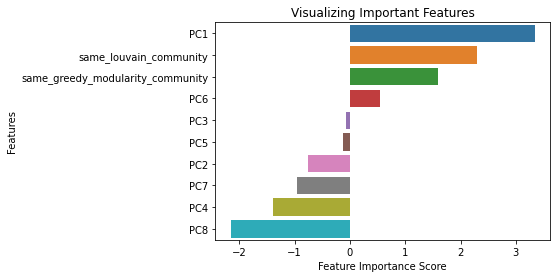

In [100]:
# Creating a bar plot
sns.barplot(x=feat_imp_lg, y=feat_imp_lg.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [101]:
imp_lg = pd.Series(
    permutation_importance(model_lg, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_lg

PC1                                 0.156869
same_louvain_community              0.022515
PC4                                 0.015147
PC2                                 0.014593
same_greedy_modularity_community    0.007599
PC8                                 0.003249
PC6                                 0.001847
PC5                                 0.001204
PC7                                 0.000481
PC3                                 0.000050
dtype: float64

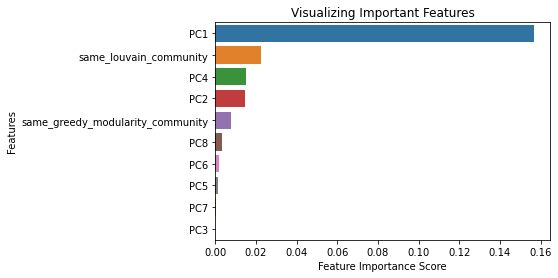

In [102]:
# Creating a bar plot
sns.barplot(x=imp_lg, y=imp_lg.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

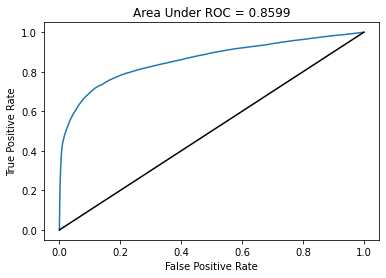

In [103]:
auc_lg = metrics.roc_auc_score(y_test, y_pred_lg)
false_positive_rate_lg, false_negative_rate_lg, _ = metrics.roc_curve(y_test,  y_pred_lg)

plt.plot(false_positive_rate_lg,false_negative_rate_lg)
plt.title(f"Area Under ROC = {np.round(auc_lg, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

## Logistic Regression with GridSearch parameters

In [104]:
model_lg_GS   = LogisticRegression(C= 0.001, penalty = 'l2', solver = "liblinear")
y_pred_lg_GS     = model_lg_GS.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [105]:
model_lg_GS.score(X_test, y_test)

0.8614573785517874

In [106]:
feat_imp_lg_GS = pd.Series(np.round(model_lg_GS.coef_[0],3),
          index=X_train.columns
).sort_values(ascending=False)
feat_imp_lg_GS

PC1                                 2.496
same_louvain_community              2.050
same_greedy_modularity_community    1.440
PC3                                -0.016
PC5                                -0.138
PC7                                -0.142
PC8                                -0.162
PC6                                -0.315
PC2                                -0.614
PC4                                -1.058
dtype: float64

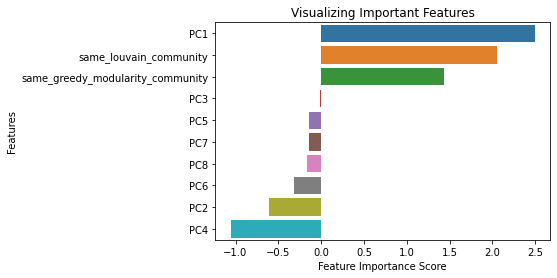

In [107]:
# Creating a bar plot
sns.barplot(x=feat_imp_lg_GS, y=feat_imp_lg_GS.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [108]:
imp_lg_GS = pd.Series(
    permutation_importance(model_lg_GS, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_lg_GS

PC1                                 0.128087
same_louvain_community              0.021185
PC2                                 0.012145
PC4                                 0.010904
same_greedy_modularity_community    0.006885
PC5                                 0.001203
PC8                                 0.000268
PC7                                 0.000058
PC3                                -0.000017
PC6                                -0.000214
dtype: float64

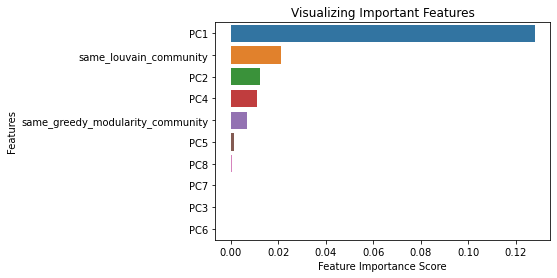

In [109]:
# Creating a bar plot
sns.barplot(x=imp_lg_GS, y=imp_lg_GS.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

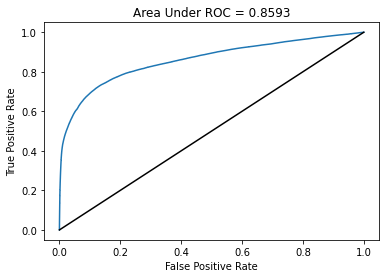

In [110]:
auc_lg_GS = metrics.roc_auc_score(y_test, y_pred_lg_GS)
false_positive_rate_lg_GS, false_negative_rate_lg_GS, _ = metrics.roc_curve(y_test,  y_pred_lg_GS)

plt.plot(false_positive_rate_lg_GS,false_negative_rate_lg_GS)
plt.title(f"Area Under ROC = {np.round(auc_lg_GS, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

Results (ROC AUC score):  
Default parameters: 0.8599  
GridSearch parameters: 0.8593  


Despite using GridSearch to find the highest scored parameter, the result of the logistic regression model with gridSearch parameter is still slightly lower than default parameter.  

# Support Vector Machines

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

* Effective in high dimensional spaces.

* Still effective in cases where number of dimensions is greater than the number of samples.

* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

## Linear Support Vector Classification

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

In [95]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
clf_svc = LinearSVC(random_state=0)

In [111]:
clf_cc = CalibratedClassifierCV(clf_svc) 
y_pred_svc = clf_cc.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [112]:
clf_cc.score(X_test, y_test)

0.8480191465526021

In [113]:
imp_svc = pd.Series(permutation_importance(clf_cc, X_test, y_test).importances_mean,
                index=X_train.columns
).sort_values(ascending=False)
imp_svc

PC1                                 0.130232
same_louvain_community              0.016915
same_greedy_modularity_community    0.009131
PC4                                 0.003750
PC2                                 0.002473
PC5                                 0.000225
PC8                                 0.000090
PC3                                -0.000006
PC7                                -0.000215
PC6                                -0.001767
dtype: float64

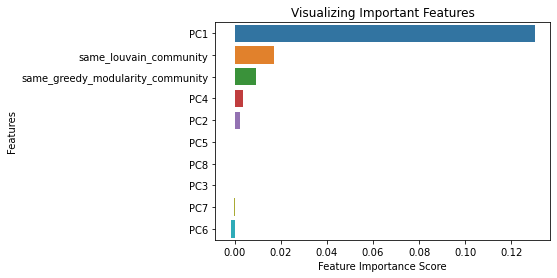

In [114]:
# Creating a bar plot
sns.barplot(x=imp_svc, y=imp_svc.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

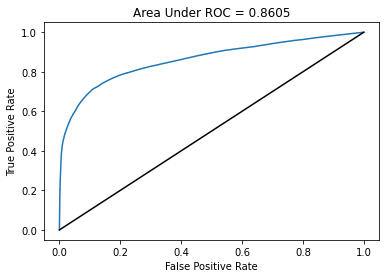

In [115]:
auc_svc = metrics.roc_auc_score(y_test, y_pred_svc)
false_positive_rate_svc, false_negative_rate_svc, _ = metrics.roc_curve(y_test,  y_pred_svc)

plt.plot(false_positive_rate_svc,false_negative_rate_svc)
plt.title(f"Area Under ROC = {np.round(auc_svc, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# Gaussian Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. 

In [116]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing = 0.7)
y_pred_gnb = gnb.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [117]:
gnb.score(X_test,y_test)

0.7869589571239434

In [118]:
imps = pd.Series(permutation_importance(gnb, X_test, y_test).importances_mean,
                index=X_train.columns
).sort_values(ascending=False)
imps

PC1                                 0.045860
PC2                                 0.004752
same_louvain_community              0.002505
same_greedy_modularity_community    0.002148
PC6                                 0.000629
PC3                                 0.000295
PC5                                 0.000237
PC7                                 0.000207
PC4                                 0.000206
PC8                                 0.000037
dtype: float64

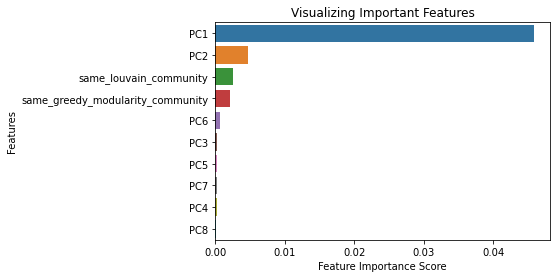

In [119]:
# Creating a bar plot
sns.barplot(x=imps, y=imps.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

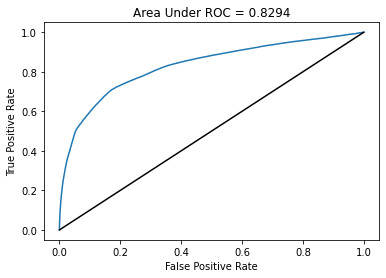

In [120]:
auc_gnb = metrics.roc_auc_score(y_test, y_pred_gnb)
false_positive_rate_gnb, false_negative_rate_gnb, _ = metrics.roc_curve(y_test,  y_pred_gnb)

plt.plot(false_positive_rate_gnb,false_negative_rate_gnb)
plt.title(f"Area Under ROC = {np.round(auc_gnb, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# Naive Bayes classifier for multivariate Bernoulli models.

Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

In [121]:
from sklearn.naive_bayes import BernoulliNB
bernou_gnb = BernoulliNB(binarize = 0.25)
y_pred_bernou_gnb = bernou_gnb.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [122]:
bernou_gnb.score(X_test,y_test)

0.8492921886139118

In [123]:
imps_bernou_gnb = pd.Series(permutation_importance(bernou_gnb, X_test, y_test).importances_mean,
                index=X_train.columns
).sort_values(ascending=False)
imps_bernou_gnb

same_louvain_community              0.028943
PC1                                 0.019907
same_greedy_modularity_community    0.015352
PC7                                 0.009591
PC8                                 0.002265
PC6                                 0.000654
PC2                                 0.000242
PC3                                 0.000000
PC4                                 0.000000
PC5                                -0.000016
dtype: float64

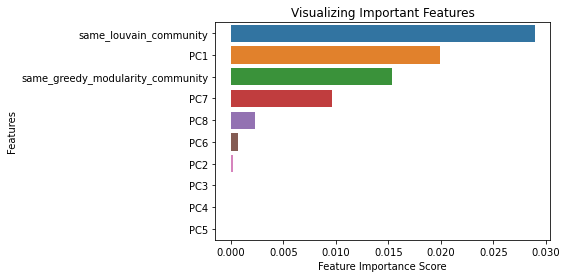

In [124]:
# Creating a bar plot
sns.barplot(x=imps_bernou_gnb, y=imps_bernou_gnb.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

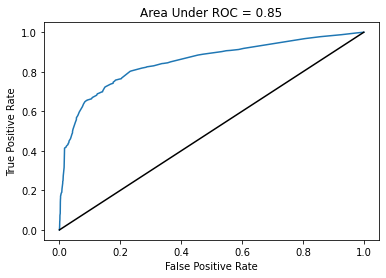

In [125]:
auc_bernou_gnb = metrics.roc_auc_score(y_test, y_pred_bernou_gnb)
false_positive_rate_bernou_gnb, false_negative_rate_bernou_gnb, _ = metrics.roc_curve(y_test,  y_pred_bernou_gnb)

plt.plot(false_positive_rate_bernou_gnb,false_negative_rate_bernou_gnb)
plt.title(f"Area Under ROC = {np.round(auc_bernou_gnb, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# Decision Trees

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. 

The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

DecisionTreeClassifier is a class capable of performing multi-class classification on a dataset.

In [126]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier(min_samples_split = 1000, max_features = 'auto', splitter='random')
y_pred_clf_dt = clf_dt.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [127]:
clf_dt.score(X_test, y_test)

0.8557694266218556

In [128]:
feature_imp_dt = pd.Series(clf_dt.feature_importances_
                           , index=X_train.columns).sort_values(ascending=False)
feature_imp_dt

same_louvain_community              0.609808
PC1                                 0.132708
same_greedy_modularity_community    0.113681
PC8                                 0.049907
PC2                                 0.030520
PC6                                 0.030236
PC3                                 0.012105
PC4                                 0.009233
PC7                                 0.008591
PC5                                 0.003213
dtype: float64

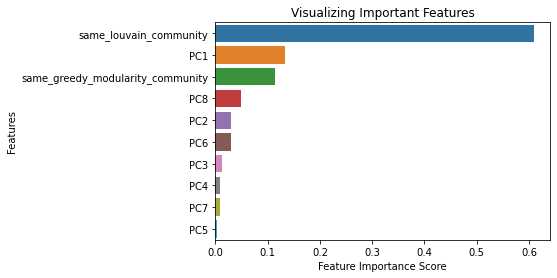

In [129]:
# Creating a bar plot
sns.barplot(x=feature_imp_dt, y=feature_imp_dt.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [130]:
imp_dt = pd.Series(
    permutation_importance(clf_dt, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_dt

PC1                                 0.147842
PC8                                 0.059536
same_louvain_community              0.042428
PC2                                 0.031991
PC6                                 0.031947
PC7                                 0.023396
PC4                                 0.017031
PC5                                 0.009948
PC3                                 0.007985
same_greedy_modularity_community    0.004935
dtype: float64

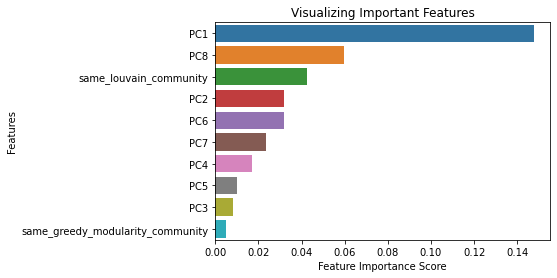

In [131]:
# Creating a bar plot
sns.barplot(x=imp_dt, y=imp_dt.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

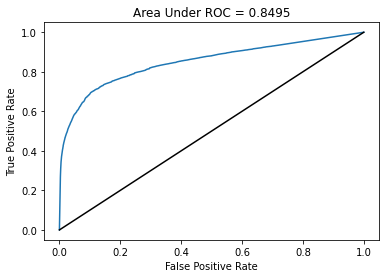

In [132]:
auc_dt = metrics.roc_auc_score(y_test, y_pred_clf_dt)
false_positive_rate_dt, false_negative_rate_dt, _ = metrics.roc_curve(y_test,  y_pred_clf_dt)

plt.plot(false_positive_rate_dt,false_negative_rate_dt)
plt.title(f"Area Under ROC = {np.round(auc_dt, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# Random Forest Classifier

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [133]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rf = RandomForestClassifier(n_estimators=200, random_state = 0, max_depth = 10, min_samples_split = 2500)

#Train the model using the training sets y_pred=clf.predict(X_test)
y_pred_clf_rf = clf_rf.fit(X_train,y_train).predict_proba(X_test)[::,1]

In [134]:
clf_rf.score(X_test, y_test)

0.8615592219166921

In [136]:
feature_imp = pd.Series(clf_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

PC1                                 0.363078
same_louvain_community              0.233862
same_greedy_modularity_community    0.187626
PC8                                 0.061816
PC7                                 0.060737
PC6                                 0.040004
PC2                                 0.032069
PC4                                 0.015089
PC5                                 0.003315
PC3                                 0.002405
dtype: float64

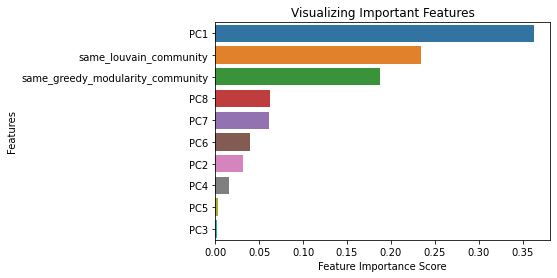

In [137]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [138]:
imp_rf = pd.Series(
    permutation_importance(clf_rf, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_rf

PC1                                 0.123077
same_louvain_community              0.032021
PC6                                 0.018181
PC2                                 0.016652
PC7                                 0.014592
PC4                                 0.007474
same_greedy_modularity_community    0.003958
PC8                                 0.003543
PC5                                 0.000154
PC3                                -0.000071
dtype: float64

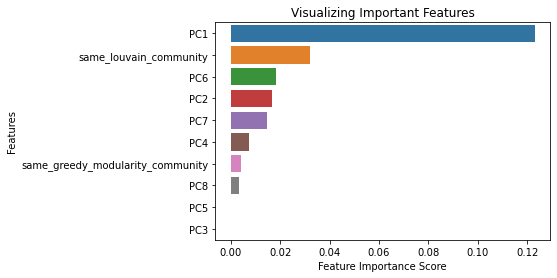

In [139]:
# Creating a bar plot
sns.barplot(x=imp_rf, y=imp_rf.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

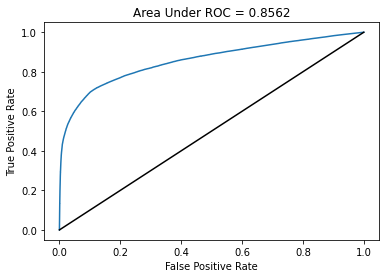

In [140]:
auc_rf = metrics.roc_auc_score(y_test, y_pred_clf_rf)
false_positive_rate_rf, false_negative_rate_rf, _ = metrics.roc_curve(y_test,  y_pred_clf_rf)

plt.plot(false_positive_rate_rf,false_negative_rate_rf)
plt.title(f"Area Under ROC = {np.round(auc_rf, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# min_samples_split = 2500 = 0.8562
# min_samples_split = 2000 = 0.8561
# min_samples_split = 1000 = 0.8554
# min_samples_split = 500 = 0.8549
# min_samples_split = default = 0.8543

# Random Forest Regressor 

## n_estimators = 100, random_state = 0, max_depth = 10, min_samples_split = 2500

In [142]:
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
rfr_100 = RandomForestRegressor(n_estimators = 100, random_state = 0, max_depth = 10, min_samples_split = 2500) # 100 trees
 
# fit the regressor with x and y data
y_pred_rfr_100 = rfr_100.fit(X_train, y_train).predict(X_test) 

In [143]:
feature_imp_rfr_100 = pd.Series(rfr_100.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp_rfr_100

PC1                                 0.763056
same_louvain_community              0.127618
same_greedy_modularity_community    0.035586
PC2                                 0.029725
PC8                                 0.013079
PC4                                 0.013040
PC6                                 0.009763
PC7                                 0.004740
PC5                                 0.002668
PC3                                 0.000724
dtype: float64

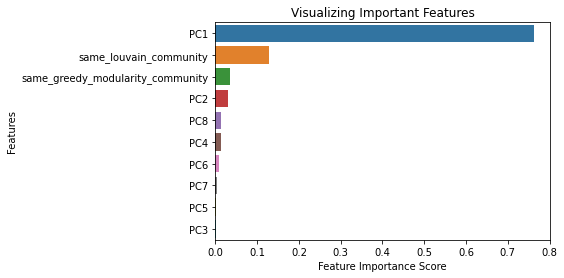

In [144]:
# Creating a bar plot
sns.barplot(x=feature_imp_rfr_100, y=feature_imp_rfr_100.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [145]:
imp_rfr_100 = pd.Series(
    permutation_importance(rfr_100, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_rfr_100

PC1                                 0.628362
same_louvain_community              0.146972
PC2                                 0.090134
PC7                                 0.083311
PC8                                 0.036138
PC4                                 0.030870
same_greedy_modularity_community    0.018812
PC6                                 0.010449
PC5                                 0.001996
PC3                                 0.000126
dtype: float64

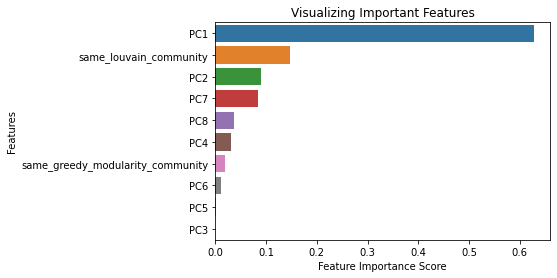

In [146]:
# Creating a bar plot
sns.barplot(x=imp_rfr_100, y=imp_rfr_100.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

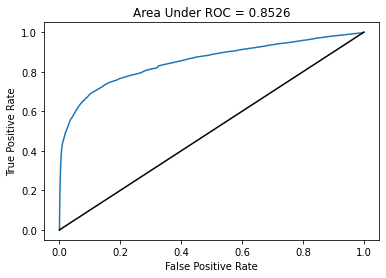

In [147]:
auc_rfr_100 = metrics.roc_auc_score(y_test, y_pred_rfr_100)
false_positive_rate_rfr_100, false_negative_rate_rfr_100, _ = metrics.roc_curve(y_test,  y_pred_rfr_100)

plt.plot(false_positive_rate_rfr_100,false_negative_rate_rfr_100)
plt.title(f"Area Under ROC = {np.round(auc_rfr_100, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

## n_estimators = 200, random_state = 0, max_depth = 10, min_samples_split = 2500

In [149]:
 # create regressor object
rfr_200 = RandomForestRegressor(n_estimators = 200, random_state = 0, max_depth = 10, min_samples_split = 2500) # 200 trees
 
# fit the regressor with x and y data
y_pred_rfr_200 = rfr_200.fit(X_train, y_train).predict(X_test) 

In [150]:
feature_imp_rfr_200 = pd.Series(rfr_200.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp_rfr_200

PC1                                 0.763045
same_louvain_community              0.127682
same_greedy_modularity_community    0.035648
PC2                                 0.029848
PC8                                 0.013034
PC4                                 0.013003
PC6                                 0.009641
PC7                                 0.004754
PC5                                 0.002653
PC3                                 0.000692
dtype: float64

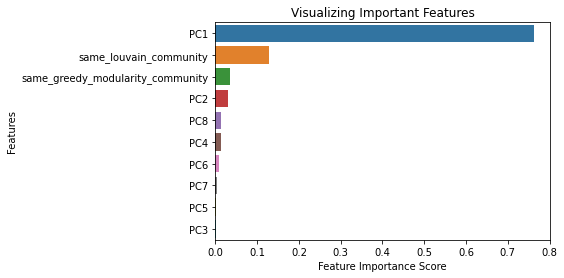

In [152]:
# Creating a bar plot
sns.barplot(x=feature_imp_rfr_200, y=feature_imp_rfr_200.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [153]:
imp_rfr_200 = pd.Series(
    permutation_importance(rfr_200, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_rfr_200

PC1                                 0.630345
same_louvain_community              0.147295
PC2                                 0.090842
PC7                                 0.083503
PC8                                 0.034553
PC4                                 0.029788
same_greedy_modularity_community    0.019143
PC6                                 0.009517
PC5                                 0.001870
PC3                                 0.000105
dtype: float64

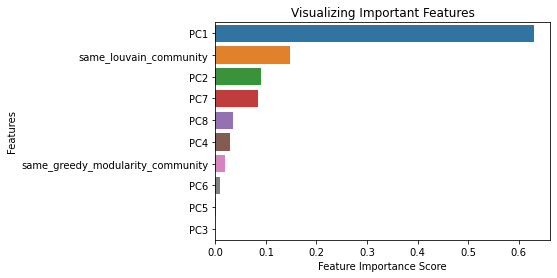

In [154]:
# Creating a bar plot
sns.barplot(x=imp_rfr_200, y=imp_rfr_200.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

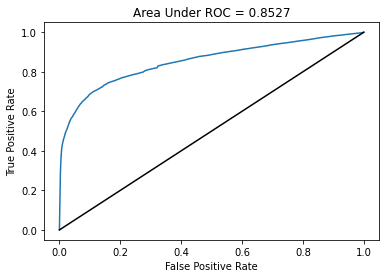

In [155]:
auc_rfr_200 = metrics.roc_auc_score(y_test, y_pred_rfr_200)
false_positive_rate_rfr_200, false_negative_rate_rfr_200, _ = metrics.roc_curve(y_test,  y_pred_rfr_200)

plt.plot(false_positive_rate_rfr_200,false_negative_rate_rfr_200)
plt.title(f"Area Under ROC = {np.round(auc_rfr_200, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# AdaBoost Classifier

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

This class implements the algorithm known as AdaBoost-SAMME.

In [156]:
from sklearn.ensemble import AdaBoostClassifier
clf_ADA = AdaBoostClassifier(n_estimators=100, random_state=0)
y_pred_clf_ADA = clf_ADA.fit(X_train,y_train).predict_proba(X_test)[::,1]

In [157]:
clf_ADA.score(X_test, y_test)

0.8604796822487015

In [158]:
feature_imp_ADA = pd.Series(clf_ADA.feature_importances_
                           , index=X_train.columns).sort_values(ascending=False)
feature_imp_ADA

PC1                                 0.34
PC4                                 0.18
PC6                                 0.12
PC5                                 0.11
PC8                                 0.07
PC3                                 0.05
PC2                                 0.04
PC7                                 0.03
same_louvain_community              0.03
same_greedy_modularity_community    0.03
dtype: float64

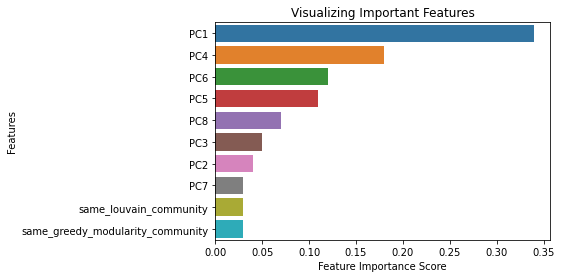

In [159]:
# Creating a bar plot
sns.barplot(x=feature_imp_ADA, y=feature_imp_ADA.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [160]:
imp_ADA = pd.Series(
    permutation_importance(clf_ADA, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_ADA

PC1                                 0.141570
same_louvain_community              0.033532
PC4                                 0.011804
same_greedy_modularity_community    0.006651
PC5                                 0.002546
PC2                                 0.002223
PC6                                 0.001568
PC3                                 0.000180
PC8                                -0.000133
PC7                                -0.000205
dtype: float64

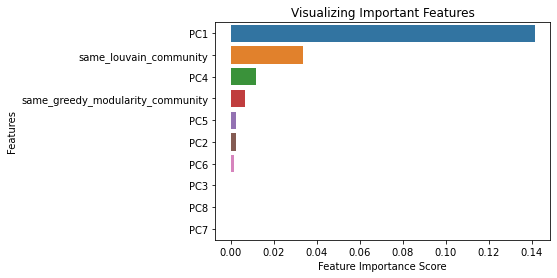

In [161]:
# Creating a bar plot
sns.barplot(x=imp_ADA, y=imp_ADA.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

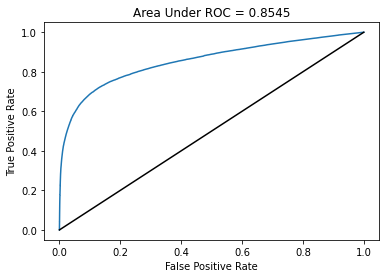

In [162]:
auc_ADA = metrics.roc_auc_score(y_test, y_pred_clf_ADA)
false_positive_rate_ADA, false_negative_rate_ADA, _ = metrics.roc_curve(y_test,  y_pred_clf_ADA)

plt.plot(false_positive_rate_ADA,false_negative_rate_ADA)
plt.title(f"Area Under ROC = {np.round(auc_ADA, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# Gradient Boosting Classifier

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced.

In [163]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
      max_depth=1, random_state=0)
y_pred_clf_GB = clf_GB.fit(X_train,y_train).predict_proba(X_test)[::,1]

In [164]:
clf_GB.score(X_test, y_test)

0.8617578164782564

In [165]:
feature_imp_GB = pd.Series(clf_GB.feature_importances_
                           , index=X_train.columns).sort_values(ascending=False)
feature_imp_GB

PC1                                 0.853121
same_louvain_community              0.107882
same_greedy_modularity_community    0.016279
PC4                                 0.008567
PC6                                 0.006460
PC8                                 0.002646
PC5                                 0.002569
PC2                                 0.002288
PC7                                 0.000133
PC3                                 0.000056
dtype: float64

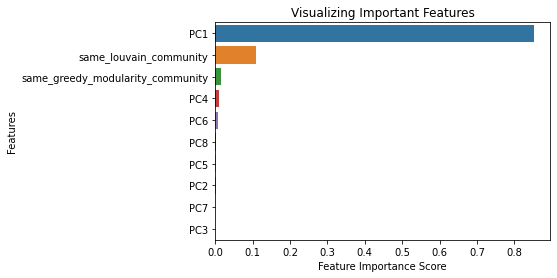

In [166]:
# Creating a bar plot
sns.barplot(x=feature_imp_GB, y=feature_imp_GB.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [167]:
imp_GB = pd.Series(
    permutation_importance(clf_GB, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_GB

PC1                                 0.169792
same_louvain_community              0.029212
PC4                                 0.015589
same_greedy_modularity_community    0.005527
PC5                                 0.004511
PC2                                 0.003276
PC6                                 0.003070
PC8                                 0.002010
PC7                                 0.000230
PC3                                -0.000052
dtype: float64

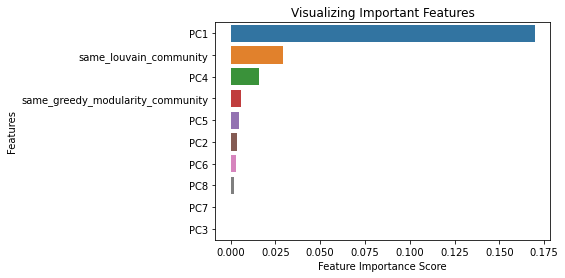

In [168]:
# Creating a bar plot
sns.barplot(x=imp_GB, y=imp_GB.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

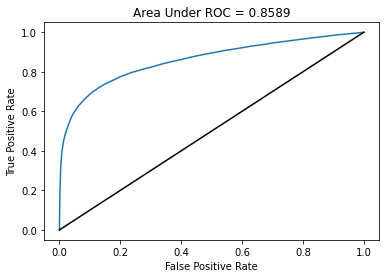

In [169]:
auc_GB = metrics.roc_auc_score(y_test, y_pred_clf_GB)
false_positive_rate_GB, false_negative_rate_GB, _ = metrics.roc_curve(y_test,  y_pred_clf_GB)

plt.plot(false_positive_rate_GB,false_negative_rate_GB)
plt.title(f"Area Under ROC = {np.round(auc_GB, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# Linear Discriminant Analysis (LDA)

A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.

The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.

The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions.

In [170]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
y_pred_lda = lda.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [171]:
lda.score(X_test, y_test)

0.8498625114573786

In [172]:
feature_imp_lda = pd.Series(lda.coef_[0]
                           , index=X_train.columns).sort_values(ascending=False)
feature_imp_lda

same_louvain_community              4.936663
same_greedy_modularity_community    2.973845
PC8                                 1.469282
PC1                                 1.436954
PC2                                 0.194259
PC3                                 0.063286
PC7                                -0.004684
PC5                                -0.064490
PC4                                -0.201391
PC6                                -2.499281
dtype: float64

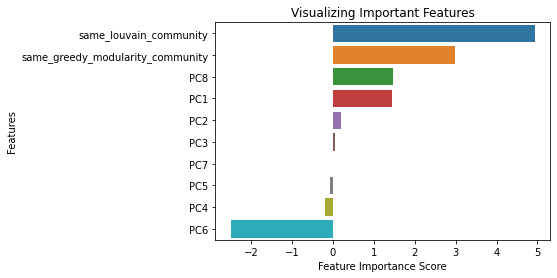

In [173]:
# Creating a bar plot
sns.barplot(x=feature_imp_lda, y=feature_imp_lda.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [174]:
imp_lda = pd.Series(
    np.round(permutation_importance(lda, X_test, y_test).importances_mean,4),
    index=X_train.columns
).sort_values(ascending=False)
imp_lda

same_louvain_community              0.0585
PC1                                 0.0262
same_greedy_modularity_community    0.0115
PC6                                 0.0036
PC5                                 0.0002
PC3                                -0.0000
PC7                                 0.0000
PC8                                -0.0000
PC4                                -0.0004
PC2                                -0.0007
dtype: float64

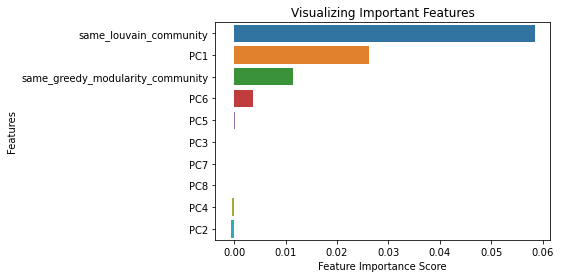

In [175]:
# Creating a bar plot
sns.barplot(x=imp_lda, y=imp_lda.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

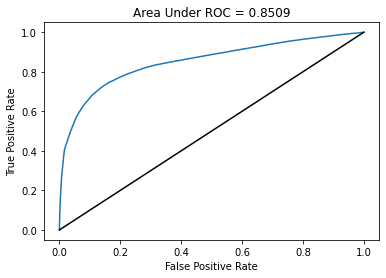

In [176]:
auc_lda = metrics.roc_auc_score(y_test, y_pred_lda)
false_positive_rate_lda, false_negative_rate_lda, _ = metrics.roc_curve(y_test,  y_pred_lda)

plt.plot(false_positive_rate_lda,false_negative_rate_lda)
plt.title(f"Area Under ROC = {np.round(auc_lda, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()

# Quadratic Discriminant Analysis (QDA)

A classifier with a quadratic decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.

The model fits a Gaussian density to each class.

In [177]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(reg_param = 0.001)
y_pred_qda = qda.fit(X_train, y_train).predict_proba(X_test)[::,1]

In [178]:
qda.score(X_test, y_test)

0.8452897443731541

In [179]:
imp_qda = pd.Series(
    permutation_importance(qda, X_test, y_test).importances_mean,
    index=X_train.columns
).sort_values(ascending=False)
imp_qda

PC1                                 0.195632
PC2                                 0.170325
PC6                                 0.097738
PC4                                 0.088616
PC7                                 0.064806
PC8                                 0.049723
PC5                                 0.005558
same_louvain_community              0.003020
same_greedy_modularity_community    0.000655
PC3                                -0.000598
dtype: float64

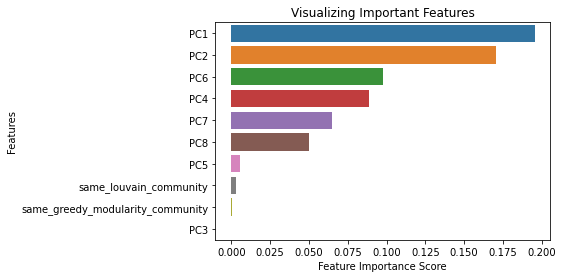

In [180]:
# Creating a bar plot
sns.barplot(x=imp_qda, y=imp_qda.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

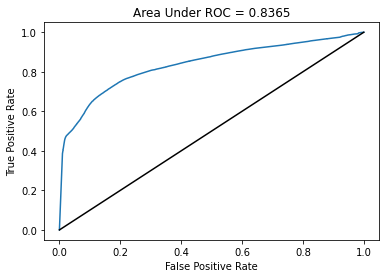

In [181]:
auc_qda = metrics.roc_auc_score(y_test, y_pred_qda)
false_positive_rate_qda, false_negative_rate_qda, _ = metrics.roc_curve(y_test,  y_pred_qda)

plt.plot(false_positive_rate_qda,false_negative_rate_qda)
plt.title(f"Area Under ROC = {np.round(auc_qda, 4)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1], [0,1], color = "black")
plt.show()
# reg_param = defalut(0) : 0.8363
# reg_param = defalut(0.0001) : 0.8364
# reg_param = defalut(0.001) : 0.8365
# reg_param = defalut(0.01) : 0.8357
# reg_param = defalut(0.1) : 0.8363


In [182]:
auc_comparison = pd.Series(
    [auc_lg, auc_svc,auc_gnb,auc_bernou_gnb,auc_dt, auc_rf, auc_rfr_200, auc_ADA, auc_GB, auc_lda, auc_qda],
                index=['Logistic Regression(Default)', 'SVM', 'Gaussian Naive Bayes', 'Bernoulli Naive Bayes', 'Decision Tree', 'Random Forest Classifier', 'Random Forest Regressor'
, 'AdaBoost Classifier', 'GradientBoosting Classifier', 'LDA', 'QDA']
).sort_values(ascending=False)

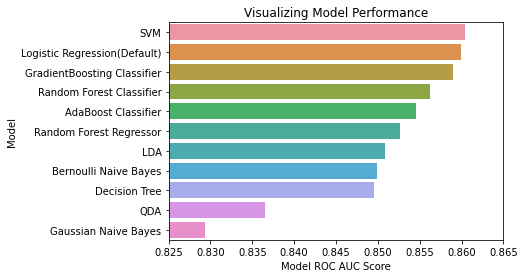

In [183]:
# Creating a bar plot
sns.barplot(x=auc_comparison, y=auc_comparison.index)
# Add labels to your graph
plt.xlabel('Model ROC AUC Score')
plt.xlim(0.825, 0.865)
plt.ylabel('Model')
plt.title("Visualizing Model Performance")
plt.show()

Source:  
[Algorithms](https://networkx.org/documentation/stable/reference/algorithms/index.html)   
[Supervised learning](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)  
[How to improve AUC?](https://www.linkedin.com/pulse/how-improve-auc-amanda-zou/)  
[Data Source-Facebook Wall Post](http://konect.cc/networks/facebook-wosn-wall/)  
[What is a Variance Inflation Factor?](https://www.statisticshowto.com/variance-inflation-factor/)  
[Joint Link Prediction in Temporal Networks](http://snap.stanford.edu/class/cs224w-2015/projects_2015/Joint_Link_Prediction_in_Temporal_Networks.pdf)  
[The Link-Prediction Problem for Social Networks](https://asistdl.onlinelibrary.wiley.com/doi/pdf/10.1002/asi.20591?casa_token=VqJIFBa34OkAAAAA:ee-9ZoxSHsfdiqtB0HNmch1UaX9QIVwn9kf6NnqRU7jY-Tcz87ysAcMbVFptGL_-6Pwogag4-rEUww)  
[Lecture Note 9 Link Prediction and Feedback Loops](https://www.philchodrow.com/intro-networks/chapters/prediction_feedback_loops.html)  
[What is Multicollinearity? Here’s Everything You Need to Know](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/)  
[Principal Component Analysis (PCA) in Python with Scikit-Learn](https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/)  
[Link prediction in social networks using machine learning methods](https://github.com/simejanko/link-prediction/blob/master/paper.pdf)  
[A Guide to Link Prediction – How to Predict your Future Connections on Facebook](https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/)  